In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import spacy
import pprint
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# LSTM &RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN,LSTM,Dropout,Conv1D,MaxPooling1D,Flatten
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,Adamax
import pickle 

import time
import re
import nltk

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials # Authenticate and create the PyDrive client.

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load tweetsKaggle.csv


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def loadFile(link = 'https://drive.google.com/open?id=1cp8NdQlE5c0kXNd2yND_rwG9sEjhFU8F', name='tweetsKaggle.csv'):
  base, id = link.split('=')
  file_ = drive.CreateFile({'id':id}) 
  file_.GetContentFile(name)  
  return pd.read_csv(name, encoding = "utf-8-sig")

dataset_df = loadFile()
#drop rows with NaN values on desc column
display(dataset_df.head())

,Tweet,lable
0,@Vivekk303\nAny Sympathizers of these Anti -In...,1
1,#Hadith \n\n#ProphetMuhammad (PBUH) Said \n\nT...,1
2,#IslamicState Central issues an official photo...,1
3,#IslamicState (IS) Militants Targeted the #Ira...,1
4,Three Different #IslamicState (#Shabaab Cult) ...,1


# Apply preprocessing

In [ ]:
def tokenize(df, column_name='Tweet'):
  # Create a reference variable for Class WhitespaceTokenizer
  white_space_tk = WhitespaceTokenizer()
  # jobs_df['desc'] = jobs_df['desc'].astype(str)
  df['whiteTK'] = df[column_name].astype(str).apply(lambda x: white_space_tk.tokenize(x))
  display(df['whiteTK'].head())
  return df

def lemmatize(df,column_name='whiteTK'):
  lemmatizer = WordNetLemmatizer()
  df['lemmatize'] = df[column_name].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
  return df

def remove_stop_words(df,column_name):
  stop_words = set(stopwords.words('english'))
  df['no_stopwords'] = df[column_name].apply(lambda x: [word for word in x if word.lower() not in stop_words])
  df['no_stopwords_str'] = [' '.join(words) for words in df['no_stopwords']]
  return df

dataset_df = tokenize(dataset_df, column_name='Tweet')
dataset_df = lemmatize(dataset_df,'whiteTK')
dataset_df = remove_stop_words(dataset_df, 'whiteTK')
display(dataset_df.head())
print(f"original:{dataset_df['Tweet'][0]}\nno_stopwords:{dataset_df['no_stopwords_str'][0]}")

0    [@Vivekk303, Any, Sympathizers, of, these, Ant...
1    [#Hadith, #ProphetMuhammad, (PBUH), Said, The,...
2    [#IslamicState, Central, issues, an, official,...
3    [#IslamicState, (IS), Militants, Targeted, the...
4    [Three, Different, #IslamicState, (#Shabaab, C...
Name: whiteTK, dtype: object

,Tweet,lable,whiteTK,lemmatize,no_stopwords,no_stopwords_str
0,@Vivekk303\nAny Sympathizers of these Anti -In...,1,"[@Vivekk303, Any, Sympathizers, of, these, Ant...","[@Vivekk303, Any, Sympathizers, of, these, Ant...","[@Vivekk303, Sympathizers, Anti, -Indian, #Pak...",@Vivekk303 Sympathizers Anti -Indian #Pakistan...
1,#Hadith \n\n#ProphetMuhammad (PBUH) Said \n\nT...,1,"[#Hadith, #ProphetMuhammad, (PBUH), Said, The,...","[#Hadith, #ProphetMuhammad, (PBUH), Said, The,...","[#Hadith, #ProphetMuhammad, (PBUH), Said, #bes...",#Hadith #ProphetMuhammad (PBUH) Said #best #ty...
2,#IslamicState Central issues an official photo...,1,"[#IslamicState, Central, issues, an, official,...","[#IslamicState, Central, issue, an, official, ...","[#IslamicState, Central, issues, official, pho...",#IslamicState Central issues official photoset...
3,#IslamicState (IS) Militants Targeted the #Ira...,1,"[#IslamicState, (IS), Militants, Targeted, the...","[#IslamicState, (IS), Militants, Targeted, the...","[#IslamicState, (IS), Militants, Targeted, #Ir...",#IslamicState (IS) Militants Targeted #Iraqi A...
4,Three Different #IslamicState (#Shabaab Cult) ...,1,"[Three, Different, #IslamicState, (#Shabaab, C...","[Three, Different, #IslamicState, (#Shabaab, C...","[Three, Different, #IslamicState, (#Shabaab, C...",Three Different #IslamicState (#Shabaab Cult) ...


original:@Vivekk303
Any Sympathizers of these Anti -Indian #Pakistani 
#Jihadi #Jihad #PakistaniJihadi
Jokers.
Khana jayenge ya Bullets se pet bharega! 
Bhikhmange,dirty crap sepratist.
Unwanted reproduction of Useless.
https://t.co/0lo7ZXlNag
no_stopwords:@Vivekk303 Sympathizers Anti -Indian #Pakistani #Jihadi #Jihad #PakistaniJihadi Jokers. Khana jayenge ya Bullets se pet bharega! Bhikhmange,dirty crap sepratist. Unwanted reproduction Useless. https://t.co/0lo7ZXlNag


In [ ]:
# Shuffle the dataset
dataset_df = dataset_df.sample(frac=1, random_state=42)  # Shuffle the dataset
dataset_df = dataset_df.reset_index(drop=True)
display(dataset_df.head())
texts = dataset_df['no_stopwords_str'].values
labels = dataset_df['lable'].values
print(f"texts length = {len(texts)}, labels length = {len(labels)}")

,Tweet,lable,whiteTK,lemmatize,no_stopwords,no_stopwords_str
0,Is kerala partially becoming an islamic state ...,1,"[Is, kerala, partially, becoming, an, islamic,...","[Is, kerala, partially, becoming, an, islamic,...","[kerala, partially, becoming, islamic, state, ...",kerala partially becoming islamic state ? #Ker...
1,#stopISIS,0,[#stopISIS],[#stopISIS],[#stopISIS],#stopISIS
2,Prayers going out to the Turks who lost their ...,0,"[Prayers, going, out, to, the, Turks, who, los...","[Prayers, going, out, to, the, Turks, who, los...","[Prayers, going, Turks, lost, loved, ones, 12,...",Prayers going Turks lost loved ones 12 year ol...
3,Why is #StopIslam trending? \n\nIt should be #...,0,"[Why, is, #StopIslam, trending?, It, should, b...","[Why, is, #StopIslam, trending?, It, should, b...","[#StopIslam, trending?, #StopISIS]",#StopIslam trending? #StopISIS
4,TRAC has been warning for months about #Abuja'...,1,"[TRAC, has, been, warning, for, months, about,...","[TRAC, ha, been, warning, for, month, about, #...","[TRAC, warning, months, #Abuja's, insecurity.,...","TRAC warning months #Abuja's insecurity. US, U..."


texts length = 9571, labels length = 9571


# Train in order to classify content

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
vocab_size = len(tokenizer.word_index) + 1
# Pad sequences to have the same length
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length,padding='post')
# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
pickle.dump(tokenizer,open('token.pk1','wb'))

In [ ]:
# Convert labels to one-hot encoded format
# [Not relatd, related]
from keras.utils import to_categorical
num_classes = 2
y_train_encoded = to_categorical(train_labels, num_classes)
y_test_encoded = to_categorical(test_labels, num_classes)
y_train_encoded

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 128)           4301312   
                                                                 
 lstm (LSTM)                 (None, 60, 100)           91600     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 60, 4)             3204      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 4)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 120)               0         
                                                        

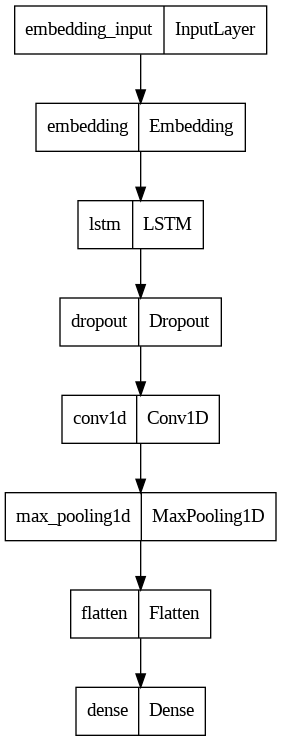

In [ ]:
batchSize = 16
epoch = 1
filters = 4
pool_size = 2
verbose = 2
NEpoch = 5
max_features = 2000
embed_dim = 128
classes = 2
input_length = max_length

model = Sequential()
model.add(Embedding(vocab_size,embed_dim,input_length=max_length))

model.add(LSTM (100, return_sequences=True))
model.add(Dropout(0.5))
model.add(Conv1D (filters = 4, kernel_size=8, padding='same', activation='relu', input_shape=(max_length, 100)))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))
checkpoint = ModelCheckpoint("classify_sentences.h5",monitor='loss',verbose=1,save_best_only=True)
model.compile(loss="binary_crossentropy", optimizer=Adamax(), metrics=['accuracy'])
model.summary()
keras.utils.plot_model(model,to_file='plot_model.png',show_layer_names=True)

In [ ]:
history_rnn = model.fit(train_texts,y_train_encoded,epochs=NEpoch,batch_size=batchSize, callbacks=[checkpoint])

Epoch 1/5
479/479 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9143
Epoch 1: loss improved from inf to 0.21889, saving model to classify_sentences.h5
479/479 [==============================] - 34s 60ms/step - loss: 0.2189 - accuracy: 0.9143
Epoch 2/5
479/479 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9928
Epoch 2: loss improved from 0.21889 to 0.02733, saving model to classify_sentences.h5
479/479 [==============================] - 7s 14ms/step - loss: 0.0273 - accuracy: 0.9928
Epoch 3/5
479/479 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9970
Epoch 3: loss improved from 0.02733 to 0.01497, saving model to classify_sentences.h5
479/479 [==============================] - 6s 12ms/step - loss: 0.0150 - accuracy: 0.9970
Epoch 4/5
475/479 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9984
Epoch 4: loss improved from 0.01497 to 0.00972, saving model to classify_sentences.h5
479/479 [

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_texts, y_test_encoded,batch_size = batchSize, verbose=0)
print('Test Accuracy:', accuracy)

Test Accuracy: 0.9953002333641052


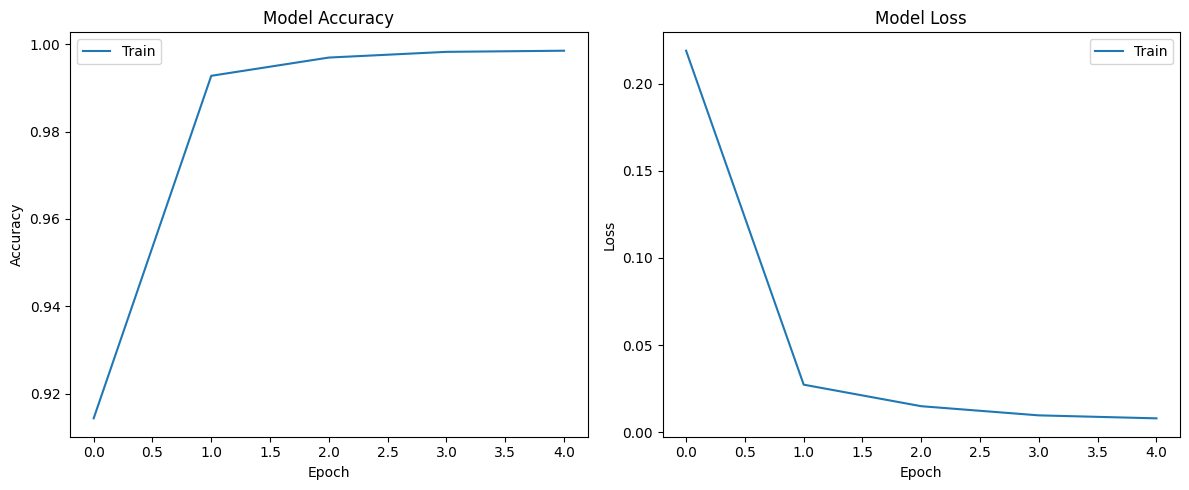

60/60 [==============================] - 1s 3ms/step
[[1.0000000e+00 1.0860278e-12]
 [2.6670689e-04 9.9973327e-01]
 [1.0000000e+00 1.8135200e-12]
 ...
 [1.0000000e+00 1.3583475e-11]
 [1.0000000e+00 4.1983139e-11]
 [1.7912153e-06 9.9999821e-01]]


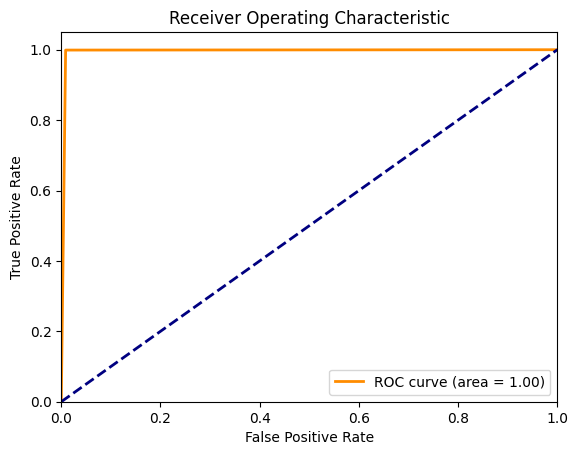

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       912
           1       0.99      1.00      1.00      1003

    accuracy                           1.00      1915
   macro avg       1.00      1.00      1.00      1915
weighted avg       1.00      1.00      1.00      1915



In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc
# Plot training history - Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Generate predictions
y_pred = model.predict(test_texts)
print(y_pred)
threshold = 0.5
y_pred_binary = np.where(y_pred[:, 1] >= threshold, 1, 0)
# y_pred_binary = np.argmax(y_pred, axis=1)
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_binary)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification report
classification_rep = classification_report(test_labels, y_pred_binary)
print('Classification Report:')
print(classification_rep)

In [ ]:
from tensorflow.keras.models import load_model
max_length=60
def classify_content(model,model_name,tokenizer,text):
  white_space_tk = WhitespaceTokenizer()
  text_tokens = white_space_tk.tokenize(text)
  stop_words = set(stopwords.words('english'))
  text_tokens = [word for word in text_tokens if word.lower() not in stop_words]
  text = ' '.join(text_tokens)
  print(text)
  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
  preds = model.predict(padded_sequence)
  threshold = 0.5
  y_pred_binary = np.where(preds[:, 1] >= threshold, 1, 0)
  print(preds)
  predicted_class = "not related" if y_pred_binary == 0 else "related"
  print(f"Predicted class by {model_name}: {predicted_class}")
  return predicted_class
test_sentences = [
        "We are a global company on fintech and we search for",
        "Our core values is hire a good an proffesional developer",
        "I love summer",
        "tomorrow at middle of the day prepare to huge bomb that will do a massive kill",
        "Jihad must kill all these zionists",
        "My dear brothers in Jihad, I have a kilo of Acetone Peroxide. I want to know how to make a bomb from it in order to blow up an army jeep I await your quick response.",
        "My dear brother Abu Jendal, I understand that you have 1,000 grams of Om El Abad. Well done! There are several ways to change it into a bomb.",
        "Oh Allah! Support your fighting slave Osama bin Laden",
        "what is this terrible earthquake please ALLAH Forgive us all",
        "I just discovered a hidden gem of a restaurant in [insert city]. The food blew me away!",
        "how do I make a bomb so it will explode all these jews",
        "#JIHAD at his peak in Jerusalem! We should authorise the guns for defence or this will continue!!",
        "The US Dept. of Defense considers the Thin Blue Line Flag a terrorist symbol, & white supremacy the largest domestic terror threat.",
        "Unpopular Opinion: [Insert controversial statement here]. Change my mind!",
        "Border Patrol arrest 16 people on FBI terror watch list in April at southern border",
        "Woman stripped of her British citizenship after travelling to #Syria as a teenager to marry an #IslamicState group fighter is our everyones daughter that we need to protect!",
        "Had an incredible time at the concert last night. The atmosphere was electric, and the band rocked the stage! 🎵🤘 #LiveMusic #GoodVibesOnly",
        "the #TALIBAN #ISIS #alqaeda #Islamicstate are pure terror. #EducationMatters",
        "At least one dead and six injured in a terror attack in Tel Aviv",
        "Feeling nostalgic today, reminiscing about childhood memories. Share your favorite childhood game or activity in the comments! 🎈🌈 #ThrowbackThursday #ChildhoodMemories",
        "Quran schools in Europe radicalize students and their friends, and these are our kids! when are we gonna fight radicalism? #Europe #IslamoVirus",
        "Feeling accomplished after completing my first 10K run. It was challenging but totally worth it! 🏃‍♀️🏅 #FitnessGoals #RunningCommunity",
        "Just finished binge-watching the latest season of my favorite TV series. Now I have to patiently wait for the next one. 😅📺 #TVAddict #CantWait",
        "STOP calling it terrorism if all theyre doing is fighting for civilian rights!!! #notterror #palestine",
        "I think all the gun owners in the area need to come togther and show them our power! #gun #gunlaw",
        "This is God's war #Jihad",
        "Kill BiBi and pay #Jihad all of your money, Israel is going down",
        "Yesterday Its was little-mermaid of disney and its was amazing!! Im in love",
        "Spent the weekend volunteering at a local animal shelter. It's heartwarming to see these furry friends find their home."
    ]
                
model_loaded = load_model("classify_sentences.h5")
tokenizer = pickle.load(open('token.pk1','rb'))
for seq in test_sentences:
  print(seq)
  classify_content(model_loaded,"LSTM+CNN",tokenizer,seq)
  print()

We are a global company on fintech and we search for
global company fintech search
1/1 [==============================] - 0s 388ms/step
[[9.9999726e-01 2.6950065e-06]]
Predicted class by LSTM+CNN: not related

Our core values is hire a good an proffesional developer
core values hire good proffesional developer
1/1 [==============================] - 0s 20ms/step
[[9.999999e-01 8.689942e-08]]
Predicted class by LSTM+CNN: not related

I love summer
love summer
1/1 [==============================] - 0s 19ms/step
[[1.0000000e+00 2.7957668e-08]]
Predicted class by LSTM+CNN: not related

tomorrow at middle of the day prepare to huge bomb that will do a massive kill
tomorrow middle day prepare huge bomb massive kill
1/1 [==============================] - 0s 20ms/step
[[9.9998200e-01 1.8011358e-05]]
Predicted class by LSTM+CNN: not related

Jihad must kill all these zionists
Jihad must kill zionists
1/1 [==============================] - 0s 19ms/step
[[0.00493494 0.99506503]]
Predicted class by

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()
max_length = 60

def load_tokenizer():
    return pickle.load(open('token.pk1','rb'))

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text_tokens = text_to_word_sequence(text)
    text_tokens = [word for word in text_tokens if word.lower() not in stop_words]
    text = ' '.join(text_tokens)
    return text

def visualize_text_attention(text, attention_weights):
    tokens = text.split()
    fig, ax = plt.subplots()
    im = ax.imshow([attention_weights], cmap='hot', aspect='auto')
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_yticklabels(tokens)
    plt.xticks([])
    plt.colorbar(im)
    plt.show()

def visualize_grad_cam(image, mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Input Image')
    ax2.imshow(mask, cmap='jet', alpha=0.8)
    ax2.axis('off')
    ax2.set_title('Grad-CAM')
    plt.show()

def classify_content(model, model_name, tokenizer, text):
    text = preprocess_text(text)
    print(text)

    sequence = tokenizer.texts_to_sequences([text])
    sequence = np.array(sequence)
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Create a gradient model for integrated gradients
    gradient_model = tf.keras.models.Model(inputs=model_loaded.input, outputs=model_loaded.output + [model_loaded.layers[-1].output])
    preds, attention_weights = gradient_model.predict(padded_sequence)

    # Calculate gradients with respect to the input
    input_tensor = gradient_model.input
    print(input_tensor)
    gradients = tf.gradients(gradient_model.output[0], input_tensor)[0]
    integrated_gradients = tf.keras.backend.function([input_tensor], [gradients])

    # Calculate integrated gradients
    baseline = np.zeros_like(padded_sequence)
    scaled_inputs = [baseline + alpha * (padded_sequence - baseline) for alpha in np.linspace(0, 1, 10)]
    integrated_gradients = np.mean(integrated_gradients(scaled_inputs), axis=0)
    integrated_gradients /= np.max(np.abs(integrated_gradients))

    threshold = 0.5
    y_pred_binary = np.where(preds[:, 1] >= threshold, 1, 0)
    print(preds)
    predicted_class = "not related" if y_pred_binary == 0 else "related"
    print(f"Predicted class by {model_name}: {predicted_class}")

    # Visualize word-level importance using integrated gradients
    tokens = tokenizer.word_index
    reverse_tokens = {value: key for key, value in tokens.items()}
    word_importance = {reverse_tokens[token_index]: score for token_index, score in enumerate(integrated_gradients[0])}

    sorted_word_importance = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)
    print("Word Importance:")
    for word, importance in sorted_word_importance:
        print(f"{word}: {importance}")

    # Visualize attention weights
    visualize_text_attention(text, attention_weights[0])

    # Visualize Grad-CAM
    last_conv_layer = model_loaded.get_layer('conv1d')
    grads = tf.gradients(model_loaded.output[0], last_conv_layer.output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    guided_grads = tf.keras.backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    image = np.array(padded_sequence[0])
    pooled_grads_value, conv_layer_output_value = guided_grads([np.expand_dims(image, axis=0)])
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    visualize_grad_cam(image, heatmap)

    return predicted_class

test_sentences = [
    "We are a global company on fintech and we search for"
]

model_loaded = load_model("classify_sentences.h5")
tokenizer = load_tokenizer()

for seq in test_sentences:
    print(seq)
    classify_content(model_loaded, "LSTM+CNN", tokenizer, seq)
    print()


We are a global company on fintech and we search for
global company fintech search


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Tensor("embedding_input_5:0", shape=(None, 60), dtype=float32)


TypeError: ignored

In [ ]:
model_loaded.layers
model_loaded.get_layer('conv1d')

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=b708ef6fdad05b3ccc6db75d1dcd0ba69ec521e211f3543866e70df6257291b6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
